In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm
import math
from time import time
import os

# Define the time-dependent MLP-UNet used for the toy diffusion model

In [13]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 32, time_emb_dim=32, scale = 9, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)
    
def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

# Training the toy diffusion model

In [14]:
# # generate the train data, which is a ring with radius 0.8-1.2
# train_data = np.random.randn(10000, 2)
# train_data = train_data / np.linalg.norm(train_data, axis=1, keepdims=True)
# train_data = train_data * (0.8 + 0.4 * np.random.rand(10000, 1))
# plt.scatter(train_data[:, 0], train_data[:, 1])
# plt.show()
# train_data = torch.tensor(train_data, dtype=torch.float32)

# def denoising_loss(net, batch_data, eps = 1e-5):
#     batch_len = len(batch_data)
#     noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
#     noise = torch.randn(batch_data.shape).cuda()
#     noisy_data = batch_data * torch.sqrt(1 - noisy_levels.reshape(-1,1)) + torch.sqrt(noisy_levels.reshape(-1,1)) * noise
#     predicted_noise = net(noisy_data, noisy_levels)
#     loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
#     return loss

# EPOCH = 1000

# data_dim = 2

# lr=1e-4
# batch_size = 128

# model = UNet_MLP(data_dim, 1, 1).cuda()
# EMA_model = UNet_MLP(data_dim, 1, 1).cuda()
# EMA_model.load_state_dict(deepcopy(model.state_dict()))
# train_data = train_data.cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# progress = tqdm(range(EPOCH))
# for epoch in progress:
#     avg_loss = 0
#     totals = 0
#     for batch_idx in index_iterator(len(train_data), batch_size):
#         optimizer.zero_grad()
#         loss  = denoising_loss(model, train_data[batch_idx])
#         loss.backward()
#         optimizer.step()
#         totals += len(batch_idx)
#         avg_loss += loss.item() * len(batch_idx)
    
#     for p, ema_p in zip(model.parameters(), EMA_model.parameters()):
#         ema_p.data.mul_(0.99).add_(0.01, p.data)

#     progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})

#     if (epoch + 1) % 50 == 0:
#         ema_sample_points = ddim_sampling(EMA_model, 1000, eta = 0.3)
#         sample_points = ddim_sampling(model, 1000, eta = 0.3)
#         ema_sample_points_eta0 = ddim_sampling(EMA_model, 1000, eta = 0.)
#         sample_points_eta0 = ddim_sampling(model, 1000, eta = 0.)
#         plt.figure(figsize=(5,5))
#         plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6, label="a")
#         plt.scatter(ema_sample_points[:,0], ema_sample_points[:,1], s=5,alpha=0.6, label="b")
#         plt.scatter(sample_points_eta0[:,0], sample_points_eta0[:,1], s=5,alpha=0.6, label="c")
#         plt.scatter(ema_sample_points_eta0[:,0], ema_sample_points_eta0[:,1], s=5,alpha=0.6, label="d")
#         plt.xlim(-2,2)
#         plt.ylim(-2,2)
#         plt.legend()
#         plt.title("epoch: {}".format(epoch))
#         plt.savefig("temp_results/ddim_{}_mg.png".format(epoch))
#         plt.show()
#         torch.save(model.state_dict(), "temp_results/ddim_mg_1.pth".format(epoch))
#         torch.save(EMA_model.state_dict(), "temp_results/ddim_ema_mg_1.pth".format(epoch))
#         print("saved at epoch {}".format(epoch))

# Generation function with DDIM

In [15]:
def ddim_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1., return_all = False):
    # generation
    now_coeff = 1 - eps
    interp = (1 - 2 * eps) / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    if return_all:
        all_points = []
        all_points.append(sample_points.clone())
        all_logits = []
        all_coeffs = []

    for _ in range(total_steps):
        nl = eta * np.sqrt(max([now_coeff - interp, 0])) 
      
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction
        sample_points = sample_mean + nl * torch.randn(sample_size,2).cuda()
        
        if return_all:
            all_points.append(sample_points.clone())
            log_likelihood = torch.sum(
                            -((sample_points - sample_mean ) ** 2) / (2 * (nl**2))
                        , dim = 1)
            all_logits.append(log_likelihood)
            all_coeffs.append(now_coeff)
        
        now_coeff -= interp

    if return_all:
        all_coeffs.append(now_coeff)
        return sample_points.cpu().numpy(), all_points, all_logits, all_coeffs
    
    else:
        return sample_points.cpu().numpy()


# Load the trained model

In [16]:
data_dim = 2
model = UNet_MLP(data_dim, 1, 1).cuda()
model.load_state_dict(torch.load("models/toy_diffusion.pth"))

<All keys matched successfully>

# Visualized the toy diffusion models

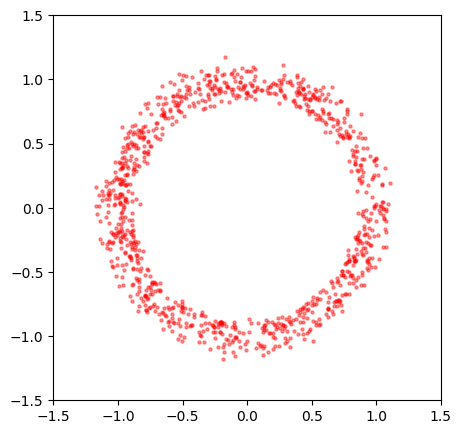

In [17]:
sample_points = ddim_sampling(model, 1000, total_steps=100, eta = 1)
# visualize reward fn
x1, x2 = np.meshgrid(np.arange(-1.5,1.5, 0.1), np.arange(-1.5,1.5, 0.1))
plt.figure(figsize=(5,5))
plt.scatter(sample_points[:,0],sample_points[:,1],c="red",s=5,alpha=0.4)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

# DNO with differentiable reward 

In [18]:
def ddim_sampling_with_grad(model, noise_vectors, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    total_steps, sample_size, _ = noise_vectors.shape
    total_steps -= 1
    interp = (1 - 2 * eps) / total_steps
    sample_points = torch.zeros_like(noise_vectors[-1].detach()) + noise_vectors[-1]

    for t in range(total_steps):
        nl = eta * np.sqrt(max([now_coeff - interp, 0])) 
      
        direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction
        sample_points = sample_mean + nl * noise_vectors[t]
        now_coeff -= interp

    return sample_points

# define the used reward function
reward_fn = lambda x: np.sin(4 * np.pi * x[:,0]) + np.sin(4 * np.pi * x[:,1]) - ((x[:,0]-1)**2 - x[:,1]**2)/5
diff_reward_fn = lambda x: torch.sin(4 * np.pi * x[:,0]) + torch.sin(4 * np.pi * x[:,1]) - ((x[:,0]-1)**2 - x[:,1]**2)/5

step: 0, loss: 0.3251079022884369


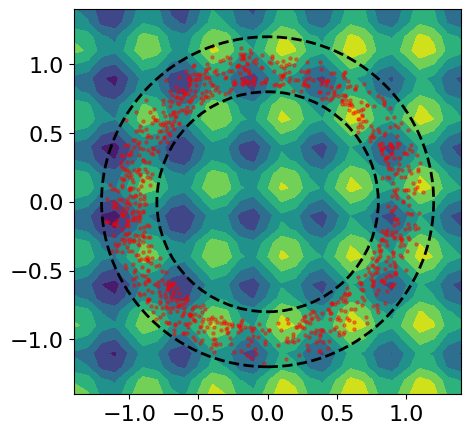

step: 20, loss: -1.0003212690353394


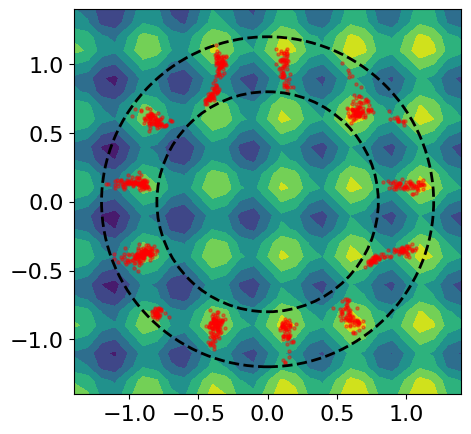

step: 40, loss: -1.2306537628173828


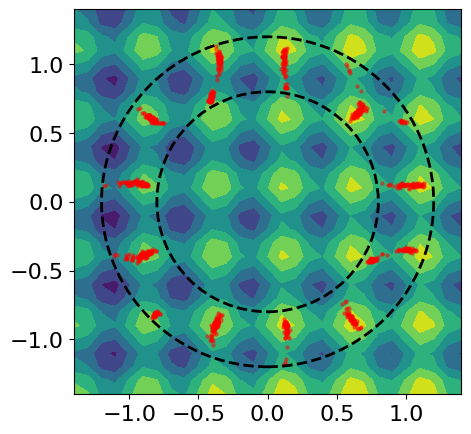

step: 60, loss: -1.3852694034576416


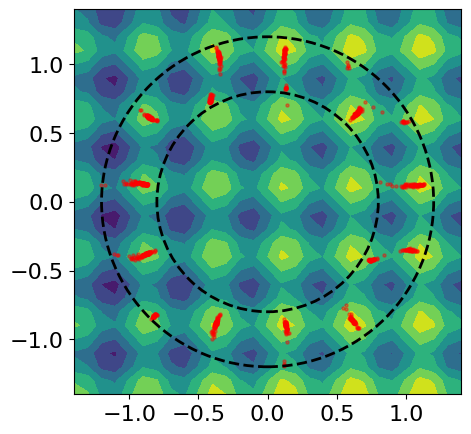

step: 80, loss: -1.4868885278701782


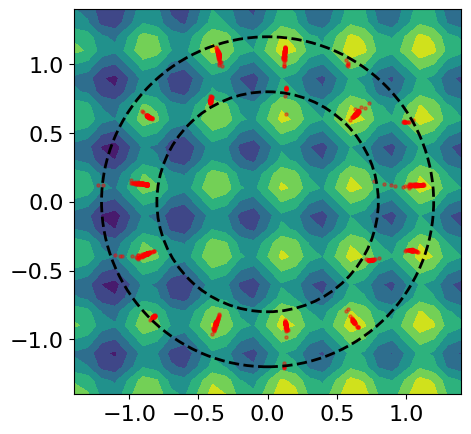

step: 100, loss: -1.5518287420272827


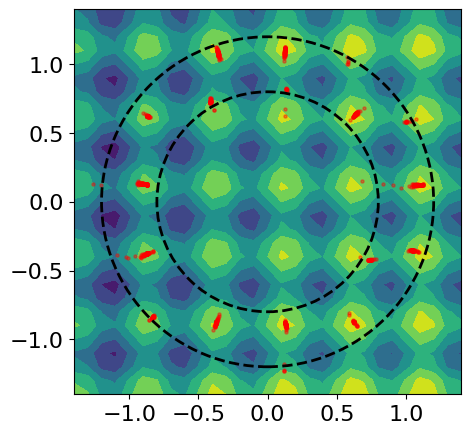

In [19]:
sample_points = ddim_sampling(model, 1000, total_steps=100, eta = 1)
# visualize reward fn
x1, x2 = np.meshgrid(np.arange(-1.5,1.5, 0.1), np.arange(-1.5,1.5, 0.1))
z_values = reward_fn(np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)],axis=1)).reshape(x1.shape)

model.requires_grad_(False)
lr = 1e-2
total_steps = 100
sample_size = 1000
eta = 1
noise_vectors = torch.randn(total_steps + 1, sample_size, 2).cuda()
noise_vectors.requires_grad_(True)
optimizer = torch.optim.Adam([noise_vectors], lr=lr)

opt_steps = 101 
for step in range(opt_steps):
    optimizer.zero_grad()
    sample_points = ddim_sampling_with_grad(model, noise_vectors,  eta = eta)
    loss = - torch.mean(diff_reward_fn(sample_points))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(noise_vectors, 1)
    optimizer.step()
    if step % 20 == 0:
        print("step: {}, loss: {}".format(step, loss.item()))
        plt.figure(figsize=(5,5))
        plt.contourf(x1,x2,z_values)
        plt.scatter(sample_points[:,0].detach().cpu().numpy(), sample_points[:,1].detach().cpu().numpy(), s=5, c="red", alpha=0.4)
        # plot a ring with radius 1
        plt.gca().add_patch(plt.Circle((0,0),1.2,color="black",alpha=1,fill=False,linewidth=2,linestyle="--"))
        plt.gca().add_patch(plt.Circle((0,0),0.8,color="black",alpha=1,fill=False,linewidth=2,linestyle="--"))
        plt.xlim(-1.4,1.4)
        plt.ylim(-1.4,1.4)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #plt.colorbar()
        
        plt.show()
    

# DNO with non-differentiable reward 

step: 0, reward: -0.3060627579689026


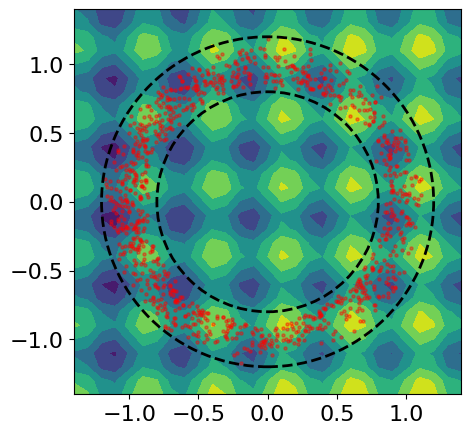

step: 50, reward: 0.8281673192977905


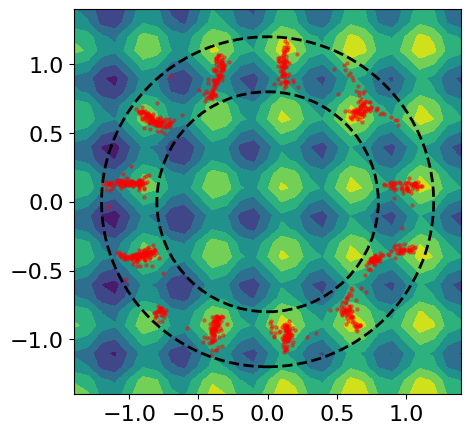

step: 100, reward: 0.8989601135253906


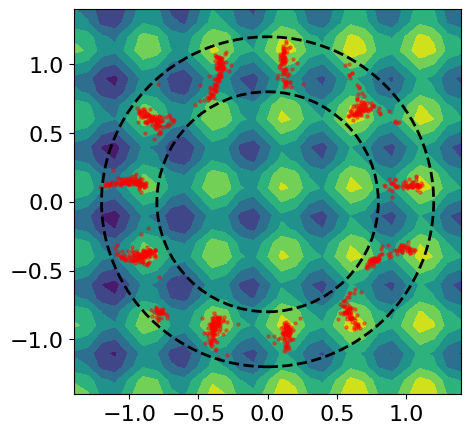

step: 150, reward: 0.9742239713668823


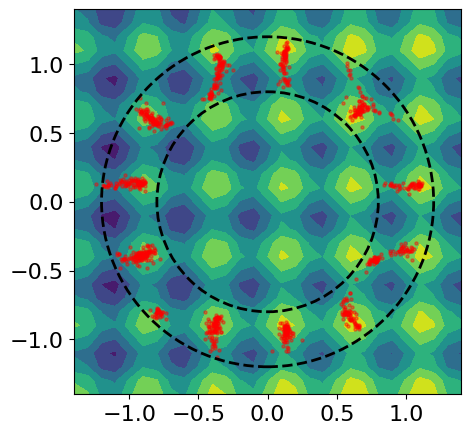

step: 200, reward: 1.0311174392700195


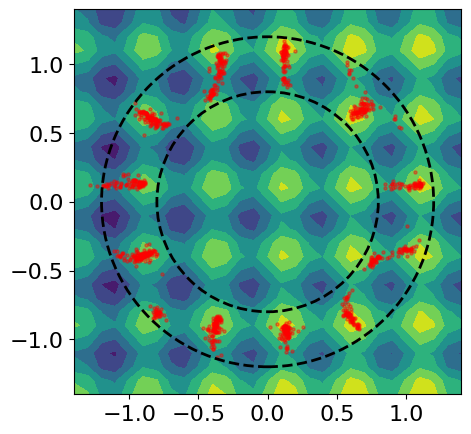

step: 250, reward: 1.079986572265625


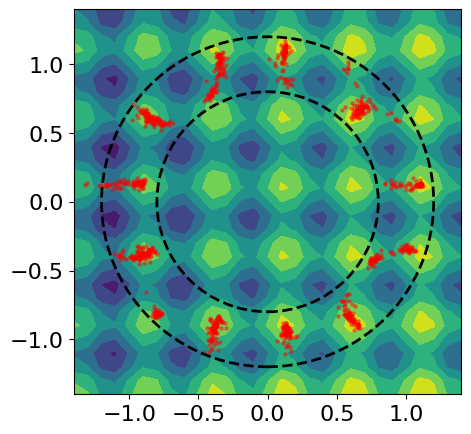

In [20]:
sample_points = ddim_sampling(model, 1000, total_steps=100, eta = 1)
# visualize reward fn
x1, x2 = np.meshgrid(np.arange(-1.5,1.5, 0.1), np.arange(-1.5,1.5, 0.1))
z_values = reward_fn(np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)],axis=1)).reshape(x1.shape)

model.requires_grad_(False)
lr = 1e-2
total_steps = 100
sample_size = 1000
eta = 1
noise_vectors = torch.randn(total_steps + 1, sample_size, 2).cuda()
noise_vectors.requires_grad_(True)
optimizer = torch.optim.Adam([noise_vectors], lr=lr)

opt_steps = 251
for step in range(opt_steps):
    optimizer.zero_grad()
    
    ######## Hybrid Gradient Approximation Strategy
    
    # 1. Perturb the initial noise_vectors to get neighbored samples
    perturbed_sample_points = []
    num_est = 2 # the number of samples used to estimate the gradient
    mu = 0.01 # the magnitude of the perturbation
    
    # generate the perturbed samples without gradient
    for _ in range(num_est):
        perturbed_noise_vectors = noise_vectors.detach() + mu * torch.randn_like(noise_vectors)
        with torch.no_grad():
            perturbed_sample_points.append(ddim_sampling_with_grad(model, perturbed_noise_vectors, eta = eta))
            
    # 2. Generate the samples with current noise_vectors with gradient,
    # In order to compute the ground-truth graident for the noise-to-sample mapping.
    
    sample_points = ddim_sampling_with_grad(model, noise_vectors,  eta = eta)
    
    # 3. Estimate the gradient of reward function w.r.t sample_points using finite-difference
    with torch.no_grad():
        sample_rewards = diff_reward_fn(sample_points)
        est_gradient = torch.zeros_like(noise_vectors)
        for i in range(num_est):
            reward_diff = sample_rewards - diff_reward_fn(perturbed_sample_points[i])
            vector_diff = sample_points - perturbed_sample_points[i]
            est_gradient += torch.einsum("i,ij->ij", reward_diff, vector_diff)
        est_gradient /= est_gradient.norm(dim=1,keepdim=True)
        
    # 4. compute the hybrid gradient estimator using gradient backpropogation
    loss = - torch.mean(sample_points * est_gradient, dim=1).sum()
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(noise_vectors, 1)
    optimizer.step()
    if step % 50 == 0:
        print("step: {}, reward: {}".format(step, sample_rewards.mean().item()))
        plt.figure(figsize=(5,5))
        plt.contourf(x1,x2,z_values)
        plt.scatter(sample_points[:,0].detach().cpu().numpy(), sample_points[:,1].detach().cpu().numpy(), s=5, c="red", alpha=0.4)
        # plot a ring with radius 1
        plt.gca().add_patch(plt.Circle((0,0),1.2,color="black",alpha=1,fill=False,linewidth=2,linestyle="--"))
        plt.gca().add_patch(plt.Circle((0,0),0.8,color="black",alpha=1,fill=False,linewidth=2,linestyle="--"))
        plt.xlim(-1.4,1.4)
        plt.ylim(-1.4,1.4)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #plt.colorbar()
        
        plt.show()
    